# 11.6 Example: hierarchical normal model

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import pandas as pd

import statistics as stat
from scipy import stats
import random

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

The initial model is an attempt to adapt the model description in 11.6, page 288.  The text specifies that the group means are θ, and the group observations are normally distributed with a common, but unknown, variance, σ.  The group means are normally distributed with mean μ and std τ. 

The hyperparameters, μ, τ, and log(σ), are uniformly distributed, with the former two strictly greater than 0.  Upper bounds are not specified: the values used were selected with little justification.

In [2]:
data = {'A': np.array([62, 20, 63, 59]),
        'B': np.array([63, 67, 71, 64,65, 66]),
        'C': np.array([68, 66, 71, 67, 68, 68]),
        'D': np.array([56, 62, 60, 61, 63, 64, 63, 59]),
        }
J = len(data)

In [3]:
ε = np.finfo(float).eps

with pm.Model() as model:
    μ = pm.Uniform("μ", lower=0 + ε, upper=100)
    τ = pm.Uniform('τ', lower=0 + ε, upper=40)
    logσ = pm.Uniform("log(σ)")
    σ = pm.Deterministic('σ', 10.0 ** logσ)
    θ = pm.Normal('θ', mu=μ, sigma=τ, shape=J) # group means
    i = 0
    for y in data:
        pm.Normal(y, mu=θ[i], sigma=σ, observed=data[y])
        i =+ 1

In [4]:
model.check_test_point()

μ_interval__          -1.39
τ_interval__          -1.39
log(σ)_interval__     -1.39
θ                    -15.66
A                    -72.98
B                    -91.22
C                   -110.32
D                    -67.36
Name: Log-probability of test_point, dtype: float64

This initial model does not sample smoothly, producing a large number of divergences with the NUTS sampler:

In [5]:
with model:
    trace = pm.sample(init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, log(σ), τ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6490833856719558, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [6]:
with model:
    idata = az.from_pymc3(trace, dims={'θ': ['Diet']}, coords={'Diet': ['A', 'B', 'C', 'D']})

In [7]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ[0],51.651,4.312,43.404,59.913,0.200,0.146,467.0,438.0,486.0,382.0,1.01
θ[1],64.468,1.832,61.219,68.068,0.054,0.038,1164.0,1164.0,1170.0,989.0,1.00
θ[2],57.378,26.380,1.193,109.834,0.711,0.503,1377.0,1377.0,1340.0,1478.0,1.01
θ[3],57.555,25.417,7.620,110.245,0.688,0.486,1366.0,1366.0,1328.0,1467.0,1.00
μ,57.483,14.438,26.290,86.423,0.422,0.300,1168.0,1157.0,1172.0,1231.0,1.01
τ,19.053,10.133,3.599,36.409,0.495,0.350,419.0,419.0,336.0,271.0,1.01
log(σ),0.915,0.048,0.835,0.999,0.002,0.001,669.0,644.0,566.0,381.0,1.00
σ,8.278,0.902,6.845,9.987,0.036,0.027,618.0,577.0,566.0,381.0,1.00


In [8]:
idata.posterior.where(idata.sample_stats['diverging'])

<xarray.Dataset>
Dimensions:  (Diet: 4, chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * Diet     (Diet) <U1 'A' 'B' 'C' 'D'
Data variables:
    θ        (chain, draw, Diet) float64 nan nan nan nan nan ... nan nan nan nan
    μ        (chain, draw) float64 nan nan nan nan nan ... nan nan nan nan nan
    τ        (chain, draw) float64 nan nan nan nan nan ... nan nan nan nan nan
    log(σ)   (chain, draw) float64 nan nan nan nan nan ... nan nan nan nan nan
    σ        (chain, draw) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    created_at:                 2020-06-15T14:37:50.546550
    arviz_version:              0.8.3
    inference_library:          pymc3
    inference_library_version:  3.8
    sampling_time:              5.406308174133301
    tuning_steps:               1000

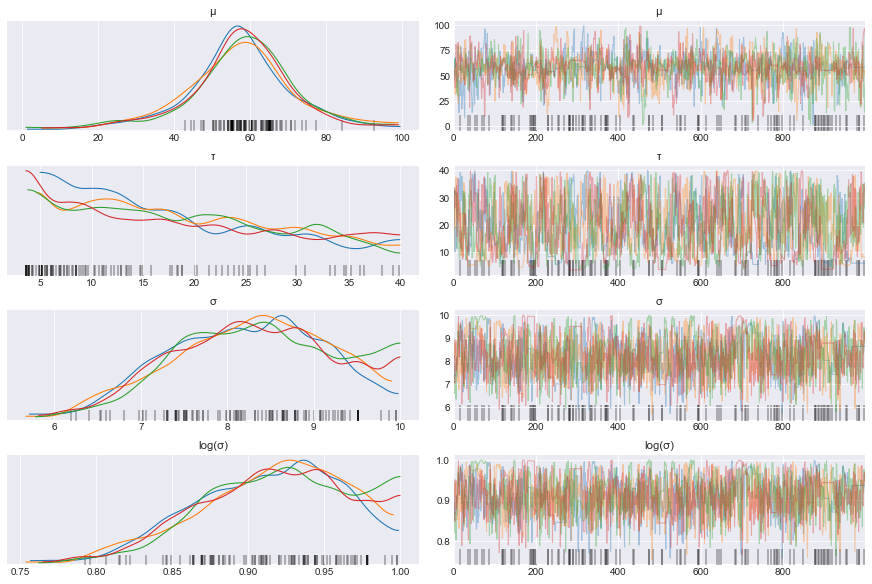

In [9]:
_ = az.plot_trace(idata, var_names=['μ', 'τ', 'σ', 'log(σ)'])

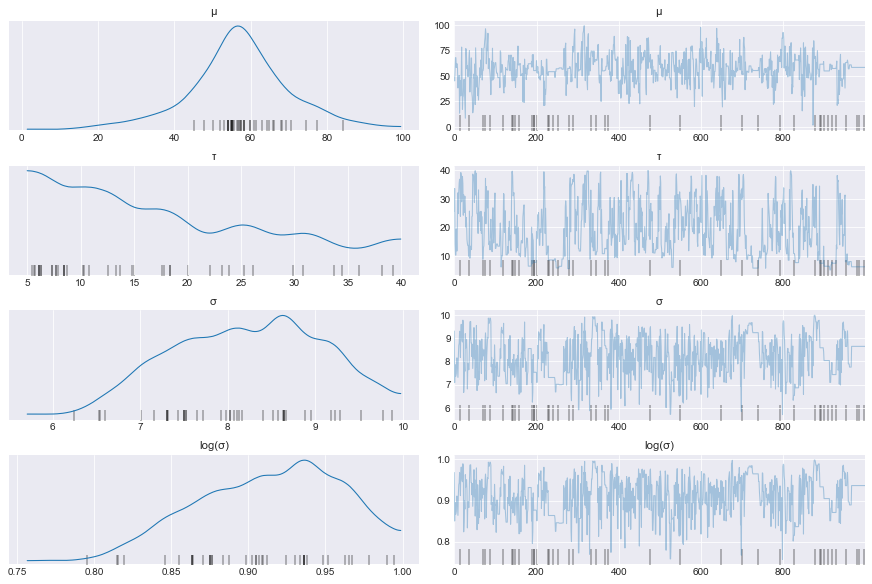

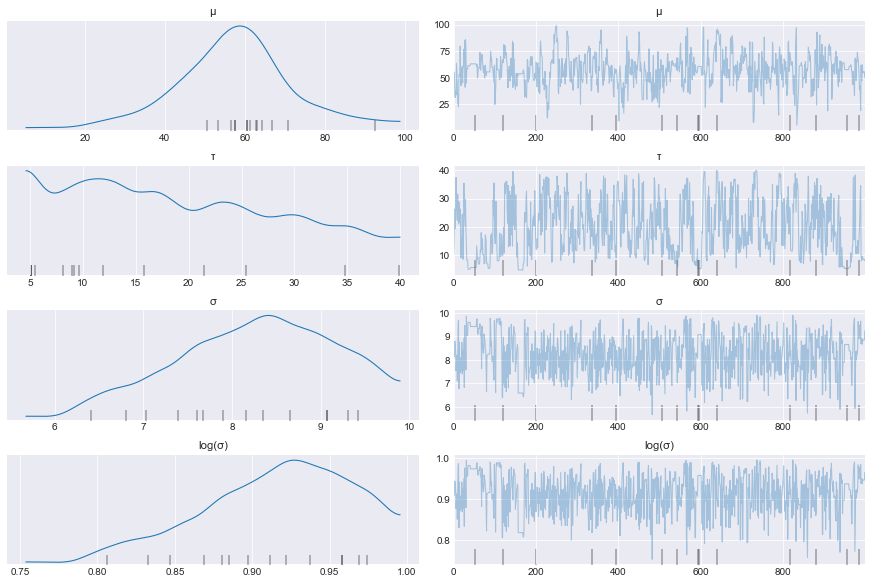

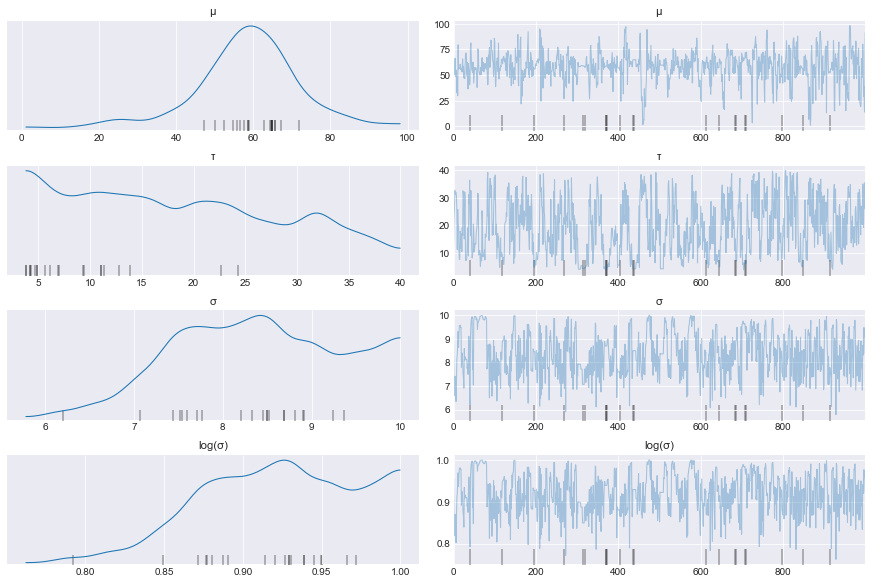

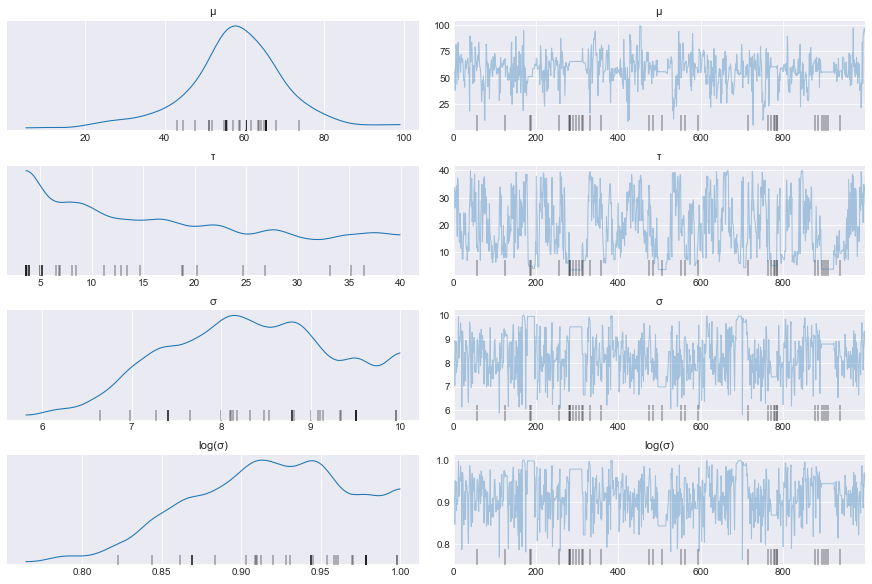

In [10]:
for x in range(4):
    _ = az.plot_trace(idata, var_names=['μ', 'τ', 'σ', 'log(σ)'], coords={'chain': [x]})

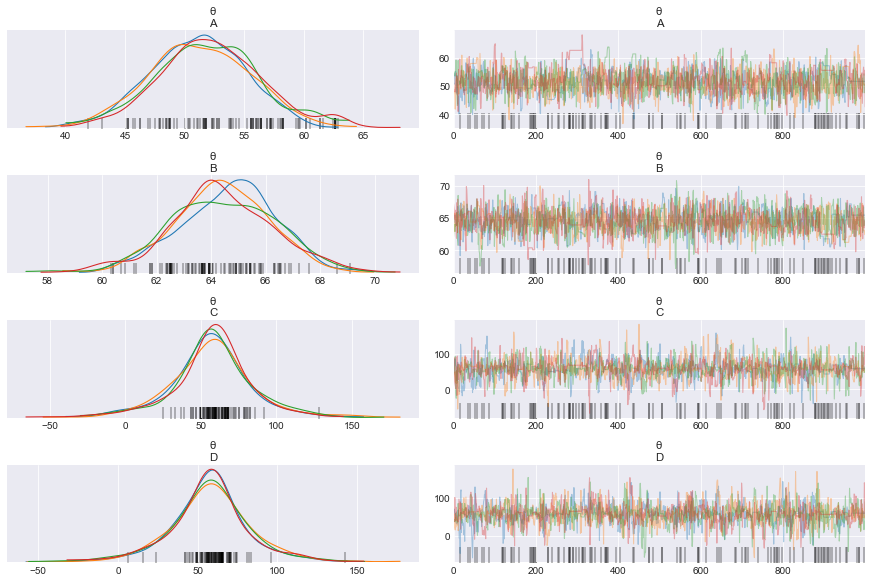

In [11]:
_ = az.plot_trace(idata, var_names=['θ'])

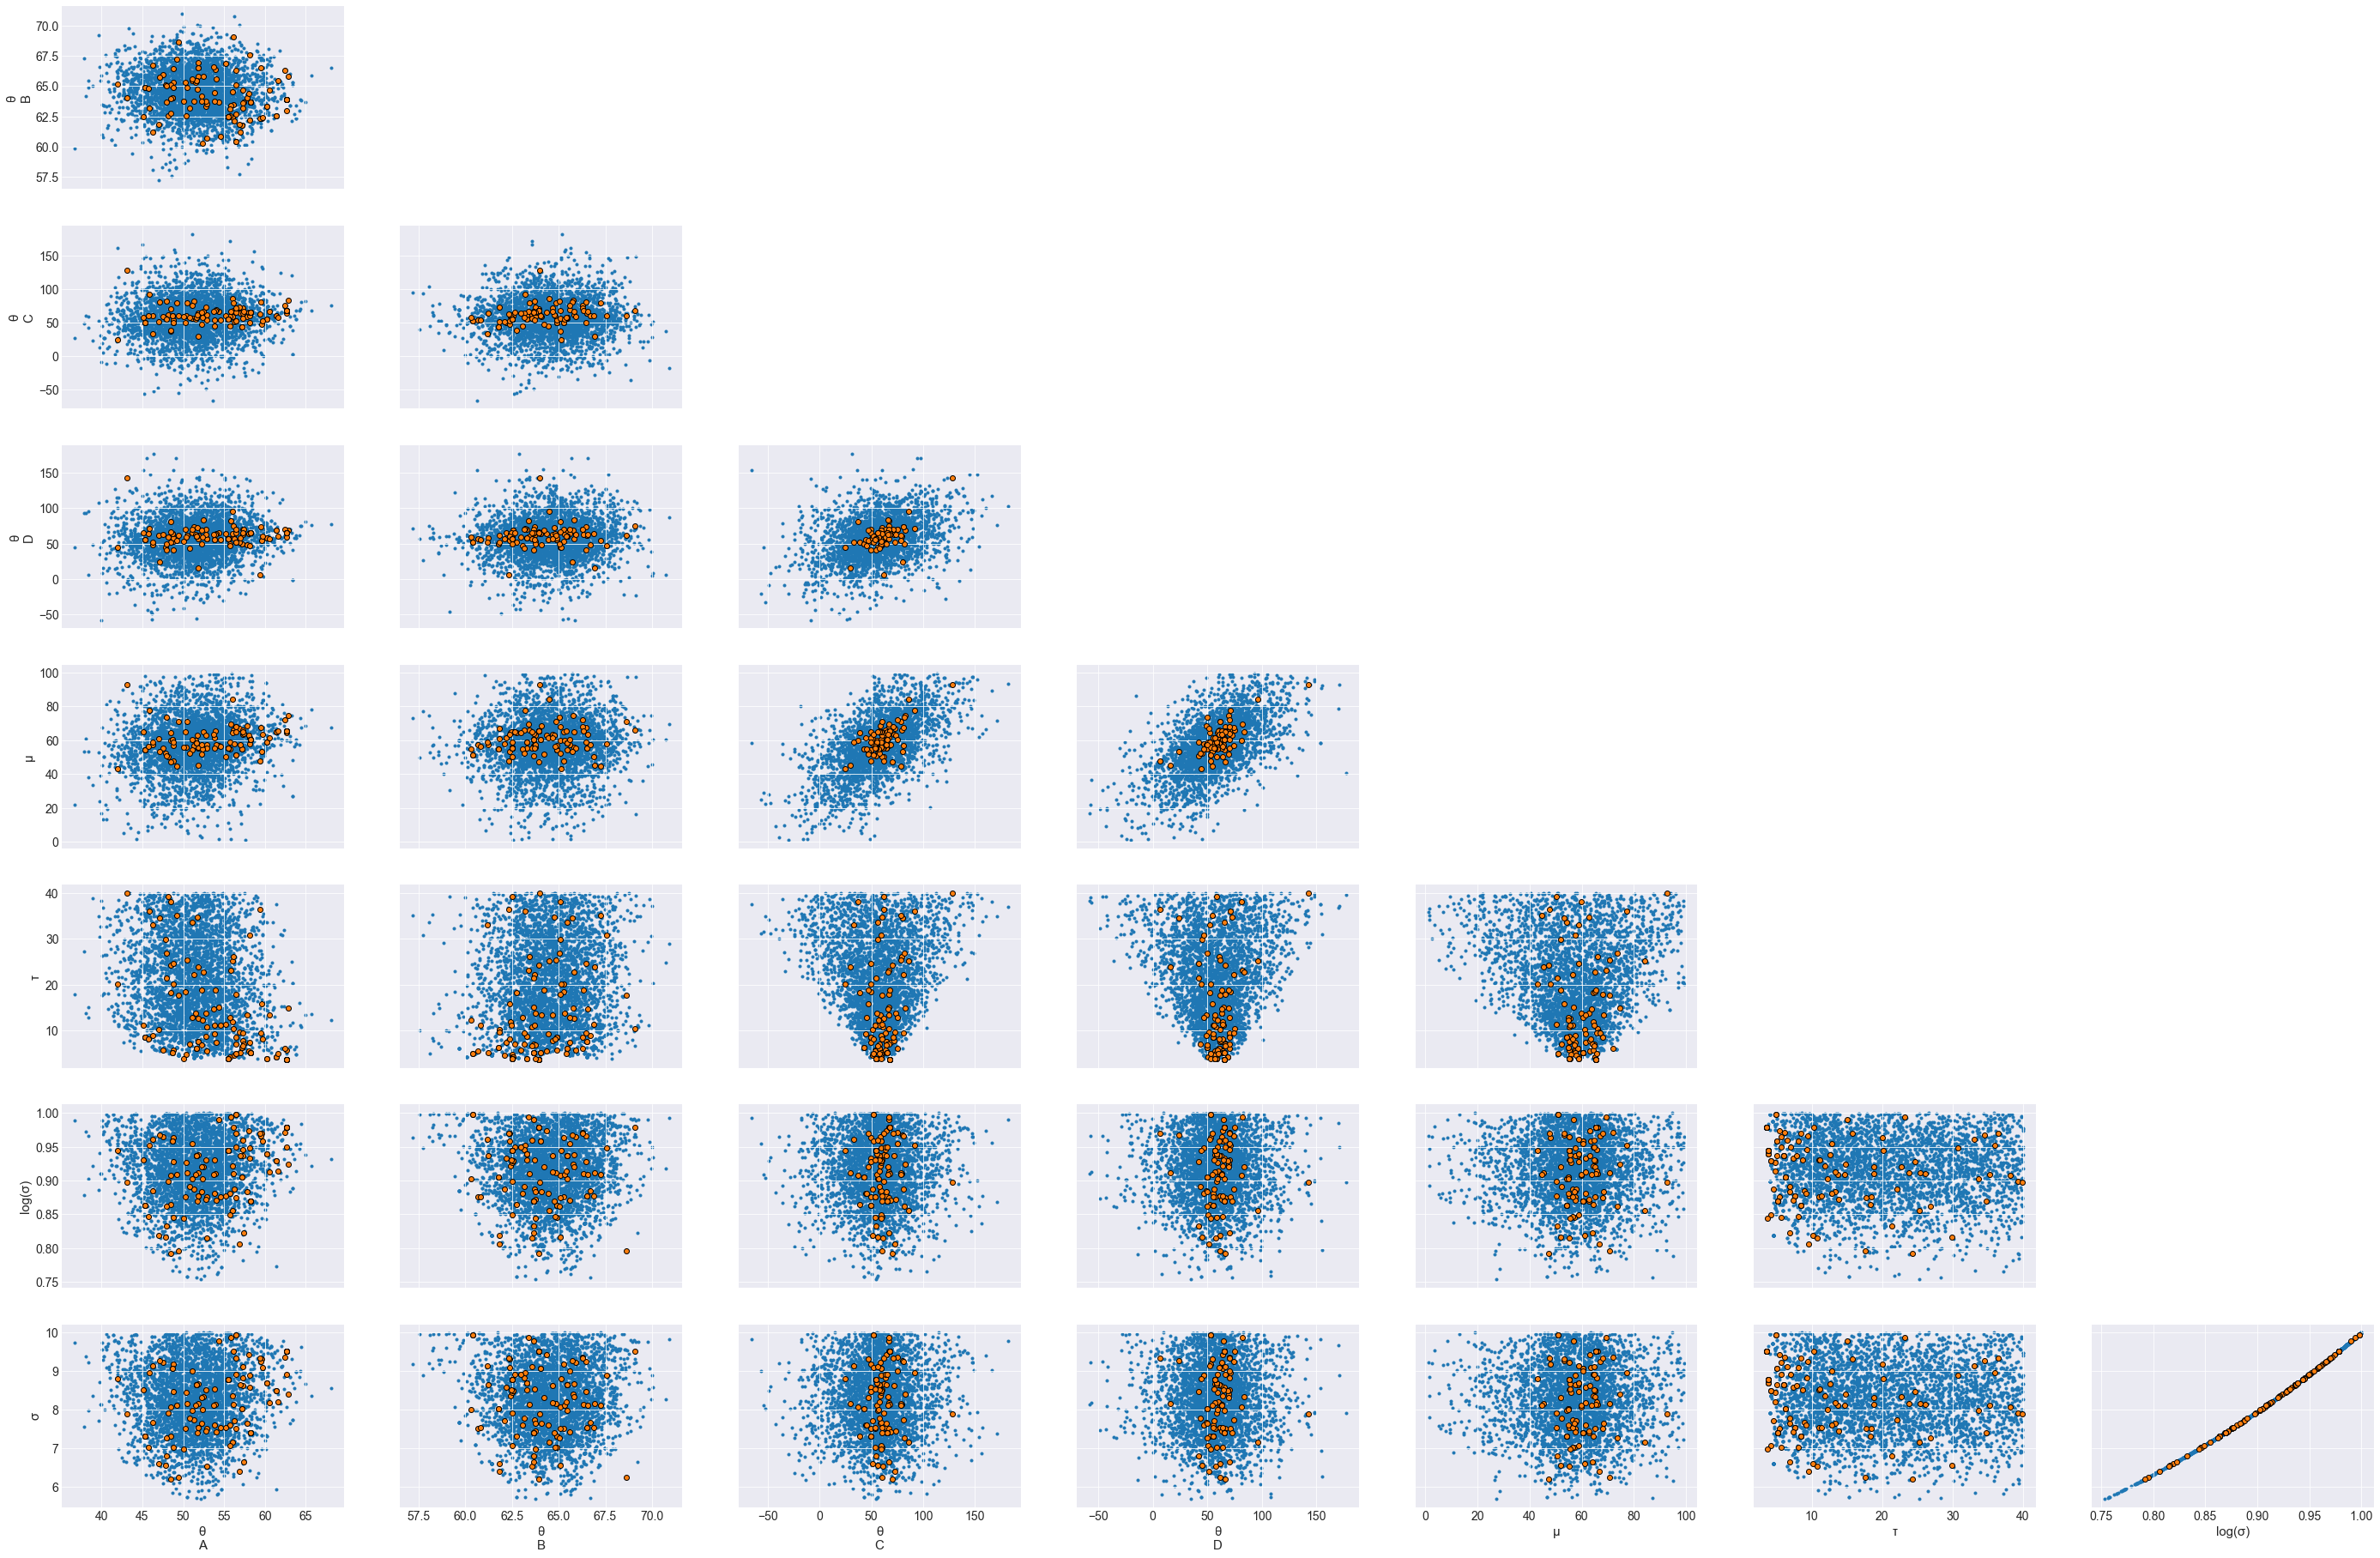

In [12]:
_ = az.plot_pair(idata, divergences=True)

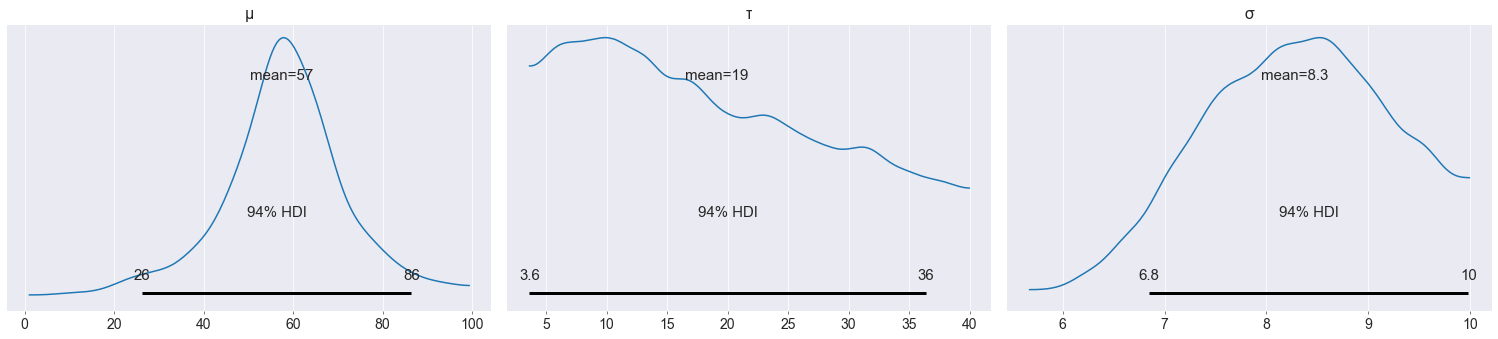

In [13]:
_ = az.plot_posterior(idata, var_names=['μ', 'τ', 'σ'])

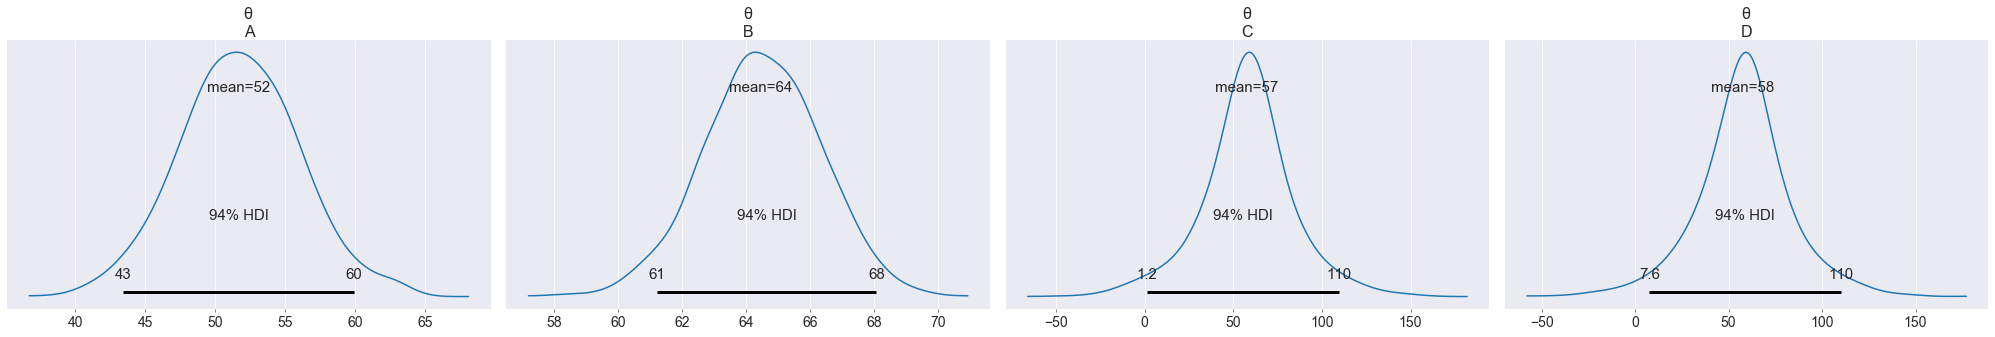

In [14]:
_ = az.plot_posterior(idata, var_names=['θ'])

In [15]:
with model:
    step = pm.Metropolis()
    trace2 = pm.sample(step=step, tune=2000, draws=2000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [θ]
>Metropolis: [log(σ)]
>Metropolis: [τ]
>Metropolis: [μ]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
with model:
    idata2 = az.from_pymc3(trace2, dims={'θ': ['Diet']}, coords={'Diet': ['A', 'B', 'C', 'D']})

In [17]:
az.summary(idata2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ[0],51.947,4.063,44.364,59.693,0.234,0.166,303.0,299.0,307.0,587.0,1.02
θ[1],64.344,1.865,60.784,67.750,0.053,0.038,1223.0,1223.0,1229.0,1595.0,1.00
θ[2],61.817,15.943,33.830,97.819,3.470,2.739,21.0,18.0,32.0,27.0,1.13
θ[3],48.838,29.844,-17.208,102.609,11.716,8.689,6.0,6.0,7.0,18.0,1.53
μ,56.343,12.236,29.208,79.194,2.384,1.705,26.0,26.0,26.0,43.0,1.11
τ,17.871,10.145,3.037,36.671,3.131,2.279,10.0,10.0,11.0,47.0,1.28
log(σ),0.917,0.049,0.835,1.000,0.002,0.001,996.0,974.0,871.0,825.0,1.01
σ,8.312,0.915,6.846,9.998,0.030,0.021,952.0,916.0,871.0,825.0,1.01


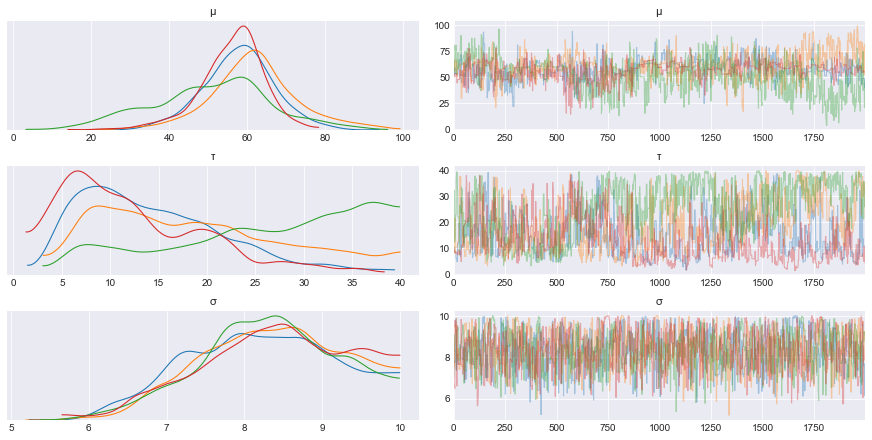

In [18]:
_ = az.plot_trace(idata2, var_names=['μ', 'τ', 'σ'])

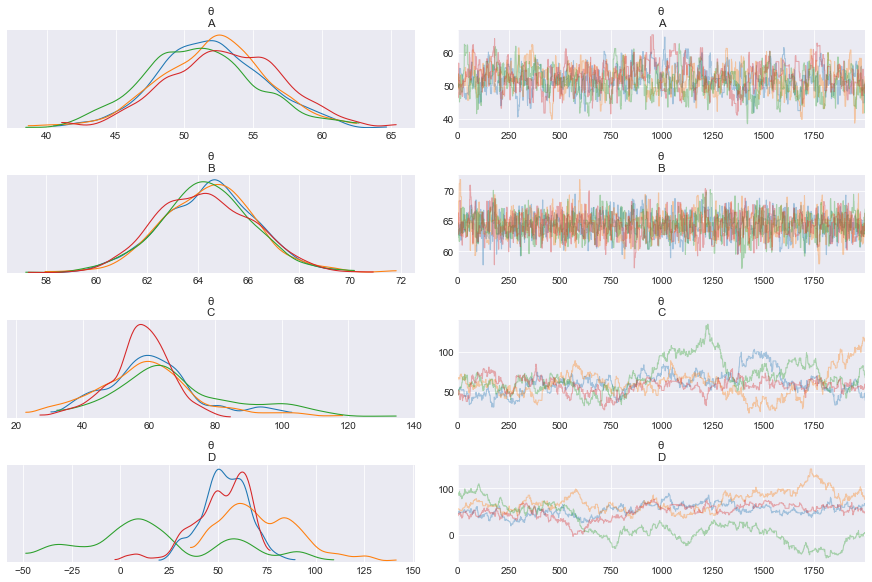

In [19]:
_ = az.plot_trace(idata2, var_names=['θ'])

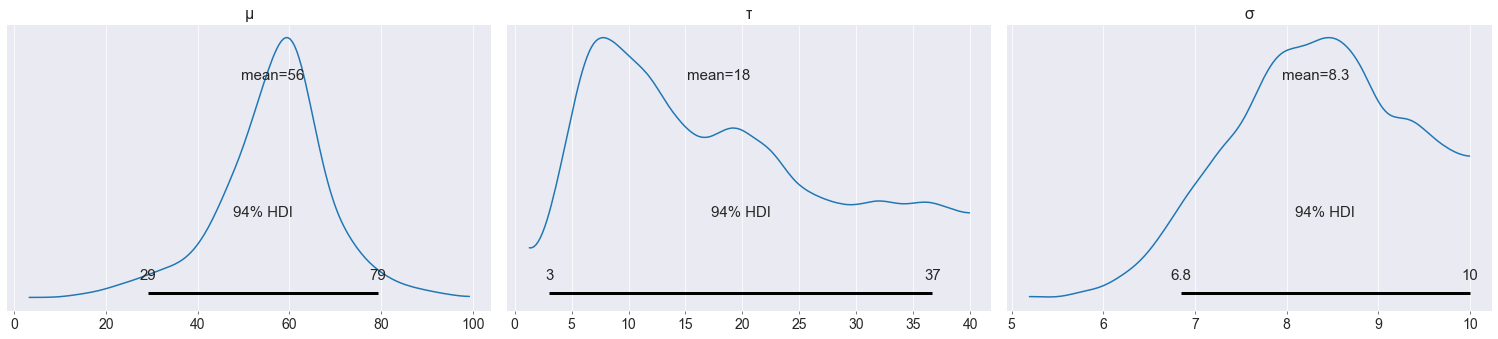

In [20]:
_ = az.plot_posterior(idata2, var_names=['μ', 'τ', 'σ'])

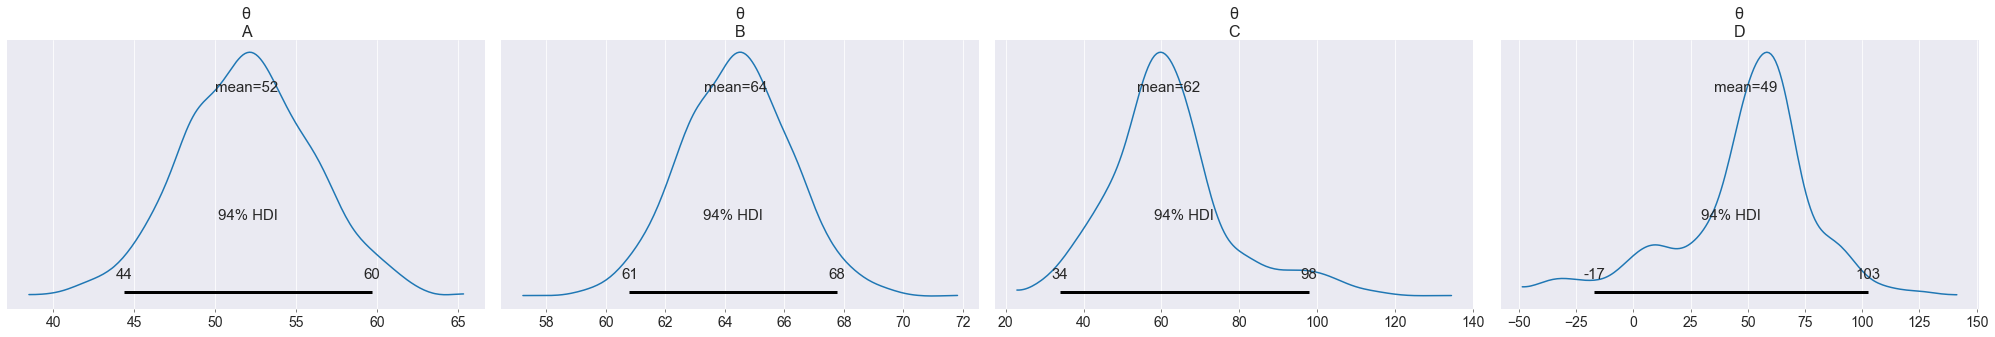

In [21]:
_ = az.plot_posterior(idata2, var_names=['θ'])

# Quantile results
In the book we see a table with the following quantiles and R-hat:

![BDA3 Table 11.3](figures/table_11_3.png)

We compute the same data for our model, as evaluated with HMC and Metropolis-Hastings.

In [22]:
def bda3_table(inf_data: az.InferenceData) -> pd.DataFrame:
    tmp = inf_data.posterior[['θ', 'μ', 'τ', 'σ']].quantile(np.array([2.5, 25, 50, 75, 97.5])/100, dim=['chain', 'draw'])

    thetas = inf_data.posterior[['θ']].quantile(np.array([2.5, 25, 50, 75, 97.5])/100, dim=['chain', 'draw']).to_dataframe().reset_index(level=1).pivot(columns='quantile')
    thetas.columns = thetas.columns.droplevel()
    thetas = thetas.rename(index={'A': 'θΑ', 'B': 'θΒ', 'C': 'θC', 'D': 'θD'})
    others = inf_data.posterior[['μ', 'σ', 'τ']].quantile(np.array([2.5, 25, 50, 75, 97.5])/100, dim=['chain', 'draw']).to_dataframe().T
    table = thetas.append(others)
    table.loc[:, 'Rhat'] = np.zeros(table.shape[0])
    table.loc[['μ', 'σ', 'τ'], 'Rhat'] = az.rhat(inf_data, var_names=['μ', 'σ', 'τ']).to_array()
    table.loc[['θΑ', 'θΒ', 'θC', 'θD'], 'Rhat'] = az.rhat(inf_data, var_names=['θ']).to_array()
    return table

In [23]:
print('BDA3 Table from HMC')
bda3_table(idata).round(2)

BDA3 Table from HMC


quantile,0.025,0.25,0.5,0.75,0.975,Rhat
θΑ,43.21,48.81,51.64,54.50,60.45,1.01
θΒ,60.75,63.27,64.47,65.70,67.98,1.00
θC,-1.63,44.58,57.67,70.04,113.45,1.01
θD,2.34,44.72,58.24,70.04,111.86,1.00
μ,24.20,50.43,57.74,65.31,87.38,1.01
σ,6.52,7.61,8.31,8.96,9.85,1.00
τ,4.19,10.32,17.59,27.15,38.40,1.01


In [24]:
print('BDA3 Table from Metropolis-Hastings')
bda3_table(idata2).round(2)

BDA3 Table from Metropolis-Hastings


quantile,0.025,0.25,0.5,0.75,0.975,Rhat
θΑ,43.95,49.10,51.97,54.69,60.07,1.02
θΒ,60.71,63.08,64.35,65.55,68.08,1.00
θC,34.94,52.51,60.15,68.16,102.70,1.13
θD,-29.45,37.68,53.95,65.19,99.00,1.53
μ,27.20,50.18,57.72,63.12,80.30,1.11
σ,6.51,7.67,8.34,8.99,9.88,1.01
τ,3.97,9.17,16.08,25.06,38.26,1.28
